In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,mean_squared_error
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
import os
from tensorflow import keras
from keras_tuner import RandomSearch
from tensorflow.keras import layers

In [2]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
df=pd.read_csv('database.csv')
df.head()

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,mie_epsilon,length_scale_factor,...,q_sca,g,c_geo,c_ext,c_abs,c_sca,ssa,mac_total,mac_bc,mac_organics
0,660,1.5,0,15.0,1,15.000000,15.000000,23.829600,2,0.0952,...,0.000389,0.003798,706.858347,0.000083,0.000083,2.750000e-07,0.003318,3.897000,3.897000,0.0
1,660,1.5,0,15.0,2,18.898816,18.898816,33.934547,2,0.0952,...,0.001005,0.008979,1122.067684,0.000173,0.000172,1.130000e-06,0.006529,4.047873,4.047873,0.0
2,660,1.5,0,15.0,4,23.811016,23.811016,48.324498,2,0.0952,...,0.002514,0.022970,1781.171422,0.000362,0.000357,4.480000e-06,0.012376,4.212336,4.212336,0.0
3,660,1.5,0,15.0,6,27.256809,27.256809,59.425643,2,0.0952,...,0.004187,0.037044,2333.994837,0.000550,0.000541,9.770000e-06,0.017756,4.248847,4.248847,0.0
4,660,1.5,0,15.0,8,30.000000,30.000000,68.816510,2,0.0952,...,0.005988,0.051049,2827.433388,0.000745,0.000728,1.690000e-05,0.022730,4.291000,4.291000,0.0


# Using vol_equi_radius_outer as input

In [4]:
X = df.iloc[:,[0,6,24,25,26,27]]
Y = df.iloc[:,[1,2]]
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y.head()

,fractal_dimension,fraction_of_coating
0,1.5,0
1,1.5,0
2,1.5,0
3,1.5,0
4,1.5,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y_train.shape[1]

2

In [7]:
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)


In [8]:
def build_model():
    model=Sequential()
    input_layer= Input(shape= (X_train.shape[1],))
    first_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(input_layer)
    second_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(first_dense)
    third_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(second_dense)
    fourth_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(third_dense)
    fifth_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(fourth_dense)
    sixth_dense=Dense(units=128, kernel_initializer='normal', activation= 'relu')(fifth_dense)
    seventh_dense=Dense(units=64, kernel_initializer='normal', activation= 'relu')(sixth_dense)
    eighth_dense=Dense(units=32, kernel_initializer='normal', activation= 'relu')(seventh_dense)
    output_dense=Dense(units=2, kernel_initializer='normal', activation= 'relu')(eighth_dense)
    #output_dense[:,0]=tf.keras.activations.sigmoid(output_dense[:,0])
    #output_q_abs=  tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,0:1])
    #output_q_sca= tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,1:2])
    #output_g= tf.keras.layers.Activation(tf.nn.sigmoid)(output_dense[:,2:3])
    #print(output_dense.shape)
   
    
    #model=tf.keras.Model(inputs=input_layer, outputs= [output_q_abs, output_q_sca, output_g])
    model=tf.keras.Model(inputs=input_layer, outputs= output_dense)
    
    return model
    
    

In [9]:
model= build_model()

#optimizer= tf.keras.optimizers.Adam(lr= 0.001)
# model.compile(optimizer='adam',
#              loss={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              },
#              metrics={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              })
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               57600     
_________________________________________________________________
dense_4 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               28800 

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


In [11]:
filepath="inverse_random_split_with_min_max_2/best_model.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [12]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [13]:
log_csv=CSVLogger('inverse_random_split_loss_logs.csv', separator=',', append=False)

In [14]:
callback_list=[checkpoint, es, log_csv]

In [15]:
history= model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/500
185/185 [==============================] - 5s 9ms/step - loss: 69156.1484 - mean_absolute_percentage_error: 69156.1484 - val_loss: 48.1387 - val_mean_absolute_percentage_error: 48.1387

Epoch 00001: val_loss improved from inf to 48.13869, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 2/500
185/185 [==============================] - 1s 7ms/step - loss: 47.6651 - mean_absolute_percentage_error: 47.6651 - val_loss: 47.3582 - val_mean_absolute_percentage_error: 47.3582

Epoch 00002: val_loss improved from 48.13869 to 47.35817, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 3/500
185/185 [==============================] - 1s 7ms/step - loss: 47.1831 - mean_absolute_percentage_error: 47.1831 - val_loss: 46.9444 - val_mean_absolute_percentage_error: 46.9444

Epoch 00003: val_loss improved from 47.35817 to 46.94443, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 4/500
185/185 [========================

Epoch 27/500
185/185 [==============================] - 1s 7ms/step - loss: 44.9415 - mean_absolute_percentage_error: 44.9415 - val_loss: 44.8968 - val_mean_absolute_percentage_error: 44.8968

Epoch 00027: val_loss improved from 44.99115 to 44.89685, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 28/500
185/185 [==============================] - 1s 7ms/step - loss: 44.8478 - mean_absolute_percentage_error: 44.8478 - val_loss: 44.8056 - val_mean_absolute_percentage_error: 44.8056

Epoch 00028: val_loss improved from 44.89685 to 44.80564, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 29/500
185/185 [==============================] - 1s 7ms/step - loss: 44.7453 - mean_absolute_percentage_error: 44.7453 - val_loss: 44.7137 - val_mean_absolute_percentage_error: 44.7137

Epoch 00029: val_loss improved from 44.80564 to 44.71367, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 30/500
185/185 [=====================

185/185 [==============================] - 1s 7ms/step - loss: 42.3389 - mean_absolute_percentage_error: 42.3389 - val_loss: 42.4822 - val_mean_absolute_percentage_error: 42.4822

Epoch 00084: val_loss did not improve from 41.98185
Epoch 85/500
185/185 [==============================] - 1s 7ms/step - loss: 42.2487 - mean_absolute_percentage_error: 42.2487 - val_loss: 42.1535 - val_mean_absolute_percentage_error: 42.1535

Epoch 00085: val_loss did not improve from 41.98185
Epoch 86/500
185/185 [==============================] - 1s 7ms/step - loss: 42.1892 - mean_absolute_percentage_error: 42.1892 - val_loss: 42.5651 - val_mean_absolute_percentage_error: 42.5651

Epoch 00086: val_loss did not improve from 41.98185
Epoch 87/500
185/185 [==============================] - 1s 7ms/step - loss: 42.2131 - mean_absolute_percentage_error: 42.2131 - val_loss: 42.0007 - val_mean_absolute_percentage_error: 42.0007

Epoch 00087: val_loss did not improve from 41.98185
Epoch 88/500
185/185 [===========

185/185 [==============================] - 1s 8ms/step - loss: 89.4519 - mean_absolute_percentage_error: 89.4519 - val_loss: 89.5597 - val_mean_absolute_percentage_error: 89.5597

Epoch 00150: val_loss did not improve from 41.63231
Epoch 151/500
185/185 [==============================] - 1s 7ms/step - loss: 89.4502 - mean_absolute_percentage_error: 89.4502 - val_loss: 89.5568 - val_mean_absolute_percentage_error: 89.5568

Epoch 00151: val_loss did not improve from 41.63231
Epoch 152/500
185/185 [==============================] - 1s 7ms/step - loss: 89.4470 - mean_absolute_percentage_error: 89.4470 - val_loss: 89.5534 - val_mean_absolute_percentage_error: 89.5534

Epoch 00152: val_loss did not improve from 41.63231
Epoch 153/500
185/185 [==============================] - 1s 7ms/step - loss: 89.4441 - mean_absolute_percentage_error: 89.4441 - val_loss: 89.5504 - val_mean_absolute_percentage_error: 89.5504

Epoch 00153: val_loss did not improve from 41.63231
Epoch 154/500
185/185 [=======

185/185 [==============================] - 2s 8ms/step - loss: 89.1549 - mean_absolute_percentage_error: 89.1549 - val_loss: 88.9260 - val_mean_absolute_percentage_error: 88.9260

Epoch 00216: val_loss did not improve from 41.63231
Epoch 217/500
185/185 [==============================] - 1s 7ms/step - loss: 89.0730 - mean_absolute_percentage_error: 89.0730 - val_loss: 88.8873 - val_mean_absolute_percentage_error: 88.8873

Epoch 00217: val_loss did not improve from 41.63231
Epoch 218/500
185/185 [==============================] - 2s 10ms/step - loss: 88.7684 - mean_absolute_percentage_error: 88.7684 - val_loss: 87.5606 - val_mean_absolute_percentage_error: 87.5606

Epoch 00218: val_loss did not improve from 41.63231
Epoch 00218: early stopping


In [16]:
# latest=tf.train.latest_checkpoint(checkpoint_dir)
weights_file = 'inverse_random_split_with_min_max_2/best_model.hdf5' # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [17]:
#model.save('random_split_model.h5')

Train loss: 41.552, Validation loss: 41.742


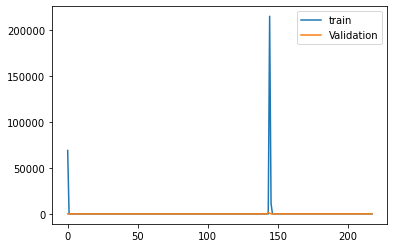

In [18]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Validation loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_percentage_error

In [20]:
Y_pred = model.predict(X_test)
#Y_pred[0]= pd.DataFrame(Y_pred[0], columns =['q_abs'])
#Y_pred[1]= pd.DataFrame(Y_pred[1], columns =['q_sca'])
#Y_pred[2]= pd.DataFrame(Y_pred[2], columns =['g'])
#predictions= pd.concat([Y_pred[0], Y_pred[1], Y_pred[2]], axis=1)
#predictions

In [21]:
error= mean_absolute_percentage_error(Y_test, Y_pred, multioutput='raw_values')   
error=error*100
print('Mean absolute percentage error on test set: ', error)

Mean absolute percentage error on test set:  [ 3.59037019 79.89417989]


# Using vol_equi_radius_outer and primary_particle_size as input

In [4]:
X = df.iloc[:,[0,3,6,24,25,26,27]]
Y = df.iloc[:,[1,2]]
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y.head()

,fractal_dimension,fraction_of_coating
0,1.5,0
1,1.5,0
2,1.5,0
3,1.5,0
4,1.5,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y_train.shape[1]

2

In [7]:
scaling_x=StandardScaler()
scaling_y=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)
Y_train=scaling_y.fit_transform(Y_train)
Y_test=scaling_y.transform(Y_test)

In [8]:
def build_model():
    model=Sequential()
    input_layer= Input(shape= (X_train.shape[1],))
    first_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(input_layer)
    second_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(first_dense)
    third_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(second_dense)
    fourth_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(third_dense)
    fifth_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(fourth_dense)
    sixth_dense=Dense(units=128, kernel_initializer='normal', activation= 'relu')(fifth_dense)
    seventh_dense=Dense(units=64, kernel_initializer='normal', activation= 'relu')(sixth_dense)
    eighth_dense=Dense(units=32, kernel_initializer='normal', activation= 'relu')(seventh_dense)
    output_dense=Dense(units=2, kernel_initializer='normal', activation= 'linear')(eighth_dense)
    #output_dense[:,0]=tf.keras.activations.sigmoid(output_dense[:,0])
    #output_q_abs=  tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,0:1])
    #output_q_sca= tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,1:2])
    #output_g= tf.keras.layers.Activation(tf.nn.sigmoid)(output_dense[:,2:3])
    #print(output_dense.shape)
   
    
    #model=tf.keras.Model(inputs=input_layer, outputs= [output_q_abs, output_q_sca, output_g])
    model=tf.keras.Model(inputs=input_layer, outputs= output_dense)
    
    return model
    
    

In [9]:
model= build_model()

#optimizer= tf.keras.optimizers.Adam(lr= 0.001)
# model.compile(optimizer='adam',
#              loss={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              },
#              metrics={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              })
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               57600     
_________________________________________________________________
dense_4 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               28800 

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


In [11]:
filepath="inverse_random_split_with_min_max_2/best_model.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [12]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [13]:
log_csv=CSVLogger('inverse_random_split_loss_logs.csv', separator=',', append=False)

In [14]:
callback_list=[checkpoint, es, log_csv]

In [15]:
history= model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/10
185/185 [==============================] - 4s 7ms/step - loss: 0.5172 - mean_absolute_error: 0.5172 - val_loss: 0.4343 - val_mean_absolute_error: 0.4343

Epoch 00001: val_loss improved from inf to 0.43426, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 2/10
185/185 [==============================] - 1s 6ms/step - loss: 0.3499 - mean_absolute_error: 0.3499 - val_loss: 0.2537 - val_mean_absolute_error: 0.2537

Epoch 00002: val_loss improved from 0.43426 to 0.25370, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 3/10
185/185 [==============================] - 1s 6ms/step - loss: 0.2327 - mean_absolute_error: 0.2327 - val_loss: 0.2414 - val_mean_absolute_error: 0.2414

Epoch 00003: val_loss improved from 0.25370 to 0.24139, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 4/10
185/185 [==============================] - 1s 6ms/step - loss: 0.1970 - mean_absolute_error: 0.1970 - val_loss: 0.1846 - val_m

In [20]:
# latest=tf.train.latest_checkpoint(checkpoint_dir)
weights_file = 'inverse_random_split_with_min_max_2/best_model.hdf5' # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [21]:
#model.save('random_split_model.h5')

Train loss: 100.908, Validation loss: 123.351


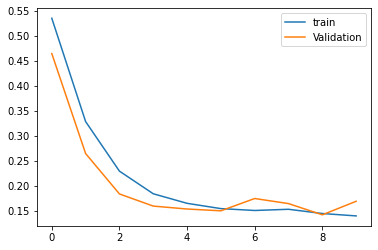

In [22]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Validation loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_percentage_error

In [24]:
Y_test=scaling_y.inverse_transform(Y_test)
Y_pred = model.predict(X_test)
Y_pred=scaling_y.inverse_transform(Y_pred)

#Y_pred[0]= pd.DataFrame(Y_pred[0], columns =['q_abs'])
#Y_pred[1]= pd.DataFrame(Y_pred[1], columns =['q_sca'])
#Y_pred[2]= pd.DataFrame(Y_pred[2], columns =['g'])
#predictions= pd.concat([Y_pred[0], Y_pred[1], Y_pred[2]], axis=1)
#predictions

In [26]:
Y_test = pd.DataFrame(data=Y_test, columns=["fractal_dimension", "fraction_of_coating"])


,fractal_dimension,fraction_of_coating
0,1.9,0.0
1,2.2,80.0
2,1.8,5.0
3,1.7,25.0
4,1.8,25.0
...,...,...
2452,1.6,5.0
2453,2.2,90.0
2454,1.6,5.0
2455,2.0,25.0


In [27]:
Y_pred

array([[ 1.8789816, -3.7007425],
       [ 2.1715426, 78.101204 ],
       [ 1.706214 ,  5.542677 ],
       ...,
       [ 1.554981 ,  1.9043103],
       [ 1.9967672, 23.03694  ],
       [ 2.2442477, -3.329065 ]], dtype=float32)

In [73]:
error= mean_absolute_error(Y_test, Y_pred, multioutput='raw_values')   
#error=error*100
print('Mean absolute  error on test set: ', error)

Mean absolute percentage error on test set:  [0.05851313 1.23322157]


# Using vol_equi_radius_outer, primary_particle_size and fractal dimension as input

In [4]:
X = df.iloc[:,[0,1,3,6,7,8,9,10,11,12,13,24,25,26,27]]
Y = df.iloc[:,[2]]
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y.head()

,fraction_of_coating
0,0
1,0
2,0
3,0
4,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y_train.shape[1]

1

In [7]:
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)


In [31]:
def build_model():
    model=Sequential()
    input_layer= Input(shape= (X_train.shape[1],))
    first_dense=Dense(units=512, kernel_initializer='he_normal', activation= 'relu')(input_layer)
    second_dense=Dense(units=512, kernel_initializer='he_normal', activation= 'relu')(first_dense)
    third_dense=Dense(units=484, kernel_initializer='he_normal', activation= 'relu')(second_dense)
    fourth_dense=Dense(units=364, kernel_initializer='he_normal', activation= 'relu')(third_dense)
    fifth_dense=Dense(units=484, kernel_initializer='he_normal', activation= 'relu')(fourth_dense)
    sixth_dense=Dense(units=484, kernel_initializer='he_normal', activation= 'relu')(fifth_dense)
    seventh_dense=Dense(units=128, kernel_initializer='he_normal', activation= 'relu')(sixth_dense)
    eighth_dense=Dense(units=128, kernel_initializer='he_normal', activation= 'relu')(seventh_dense)
    output_dense=Dense(units=1, kernel_initializer='he_normal', activation= 'linear')(eighth_dense)
    #output_dense[:,0]=tf.keras.activations.sigmoid(output_dense[:,0])
    #output_q_abs=  tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,0:1])
    #output_q_sca= tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,1:2])
    #output_g= tf.keras.layers.Activation(tf.nn.sigmoid)(output_dense[:,2:3])
    #print(output_dense.shape)
   
    
    #model=tf.keras.Model(inputs=input_layer, outputs= [output_q_abs, output_q_sca, output_g])
    model=tf.keras.Model(inputs=input_layer, outputs= output_dense)
    
    return model
    
    

In [32]:
model= build_model()

#optimizer= tf.keras.optimizers.Adam(lr= 0.001)
# model.compile(optimizer='adam',
#              loss={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              },
#              metrics={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              })
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               8192      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 484)               248292    
_________________________________________________________________
dense_12 (Dense)             (None, 364)               176540    
_________________________________________________________________
dense_13 (Dense)             (None, 484)               176660    
_________________________________________________________________
dense_14 (Dense)             (None, 484)               2347

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


In [34]:
filepath="inverse_random_split_with_min_max_2/best_model.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [35]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [36]:
log_csv=CSVLogger('inverse_random_split_loss_logs.csv', separator=',', append=False)

In [37]:
callback_list=[checkpoint, es, log_csv]

In [38]:
history= model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/10
185/185 [==============================] - 6s 18ms/step - loss: 28901524.0000 - mean_absolute_percentage_error: 28901524.0000 - val_loss: 1695759.5000 - val_mean_absolute_percentage_error: 1695759.5000

Epoch 00001: val_loss improved from inf to 1695759.50000, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 2/10
185/185 [==============================] - 3s 17ms/step - loss: 1283641.8750 - mean_absolute_percentage_error: 1283641.8750 - val_loss: 895338.0000 - val_mean_absolute_percentage_error: 895338.0000

Epoch 00002: val_loss improved from 1695759.50000 to 895338.00000, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 3/10
185/185 [==============================] - 3s 15ms/step - loss: 449806.2500 - mean_absolute_percentage_error: 449806.2500 - val_loss: 335347.6875 - val_mean_absolute_percentage_error: 335347.6875

Epoch 00003: val_loss improved from 895338.00000 to 335347.68750, saving model to inverse_random_split_with

In [39]:
# latest=tf.train.latest_checkpoint(checkpoint_dir)
weights_file = 'inverse_random_split_with_min_max_2/best_model.hdf5' # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [40]:
#model.save('random_split_model.h5')

Train loss: 81841.359, Validation loss: 80376.477


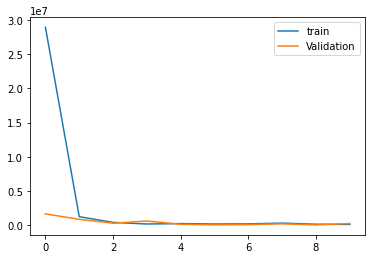

In [41]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Validation loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_percentage_error

In [43]:
Y_pred = model.predict(X_test)
#Y_pred[0]= pd.DataFrame(Y_pred[0], columns =['q_abs'])
#Y_pred[1]= pd.DataFrame(Y_pred[1], columns =['q_sca'])
#Y_pred[2]= pd.DataFrame(Y_pred[2], columns =['g'])
#predictions= pd.concat([Y_pred[0], Y_pred[1], Y_pred[2]], axis=1)
#predictions

In [52]:
error= mean_squared_error(Y_test, Y_pred, multioutput='raw_values')   
#error=error*100
print('Mean absolute percentage error on test set: ', error)

Mean absolute percentage error on test set:  [299.1627744]


ValueError: autodetected range of [-inf, -inf] is not finite

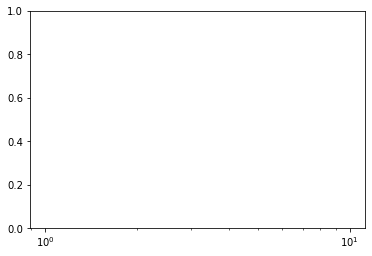

In [25]:
sb.histplot(Y_pred, log_scale=True)

In [45]:
Y_pred.shape

(2457, 1)

In [47]:
Y_pred.min()

-0.00059280626

In [76]:
df['q_sca'].min()

0.00038915